# Imports
Imports necesarios para correr el notebook

In [319]:
import pandas as pd, spacy, math, os
import matplotlib.pyplot as plt

from datetime import datetime
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud

# Cargar modelos de Spacy
Se agregó como hiperparámetro el modelo de spacy, por lo que se pre-cargaron 4 modelos diferentes de spacy para hacer pruebas al variar el modelo

In [413]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

stw = stopwords.words('english')
stw.extend(['retrieve', 'retrieved', 'isbn', 'pmid','archived','th'])
STOPWORDS = set(stw)

In [406]:
ALLOWED_POSTAGS = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PART']
NLP_MODELS = {
    'en_core_web_trf': spacy.load('en_core_web_trf'),    
    'en_core_web_sm': spacy.load('en_core_web_sm'),
    'en_core_web_md': spacy.load('en_core_web_md'),
    'en_core_web_lg': spacy.load('en_core_web_lg')
}

# Clase Model
Se definió una clase model que recibe los hiperparámetros con los que se puede entrenar el modelo. Se tomó de base la clase de Modelo utilizado en la tarea anterior.

In [646]:
class Model:
    # not necesarry but just as a 'fyi'
    raw_data = [] # constructor
    stopwords = STOPWORDS # default if not given
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    debug_history = dict()
    ngram_model = None
    words = []
    nlp = None
    nlp_text = ''
    
    def __init__(self, df, steps
                 , num_topics=10
                 , nlp_model = 'en_core_web_lg'
                 , stopwords=STOPWORDS
                 , ngrams=2
                 , min_count=5
                 , threshold=10
                 , allowed_postags=ALLOWED_POSTAGS
                 , debug = False
                 , random_state=100
                 , update_every=1
                 , chunksize=100
                 , passes=10
                 , alpha='auto'
                 , per_word_topics=True
        ):
        self.steps = steps
        self.stopwords = stopwords
        self.num_topics = num_topics
        self.raw_data = df
        self.ngram = {'min_count': min_count, 'threshold': threshold, 'ngrams': ngrams}
        self.lda_model_params = {'random_state': random_state, 'update_every': update_every, 'chunksize': chunksize, 'passes': passes, 'alpha': alpha, 'per_word_topics': per_word_topics}
        self.allowed_postags = allowed_postags
        self.debug = debug
        self.nlp_text = nlp_model
        if nlp_model not in NLP_MODELS:
            nlp_model = 'en_core_web_lg'
        self.nlp = NLP_MODELS[nlp_model]
        
    def preprocess(self, raw_data, print_steps=True):
        if print_steps:
            print(f'{datetime.now()}    sentences_as_words')
        result = self.sentences2words(raw_data)
        # iterate the pipeline
        for step in self.steps:
            if print_steps:
                print(f'{datetime.now()}    {step}')
            
            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
            elif step == 'lemmatization':
                result = self.lemmatization(result)
            elif step == 'ngram':
                # train ngram model
                ngram_model = self.train_ngrams(result, ngrams=self.ngram['ngrams'], min_count=self.ngram['min_count'], threshold=self.ngram['threshold'])

                if len(ngram_model)>0:
                    self.ngram_model = ngram_model

                    # apply ngram model
                    result = self.create_ngrams(ngram_model, result)
                else:
                    print(f'{datetime.now()} ngram not done: {self.ngram["ngram"]}')
            else:
                print(f'{datetime.now()} instruction not found: {step}')
        return result
        
    
    def fit(self, preprocess_data = None):
        
        print(f'{datetime.now()}  start')
        
        if preprocess_data == None:
            result = self.preprocess(self.raw_data)
        else:
            print(f'{datetime.now()}    using preprocess data')
            result = preprocess_data
        
        # save words in a 1d array
        words = self.array2dto1d(result)
        if (self.debug):
            self.debug_history['words'] = words
        
        # build dictionary
        dictionary = Dictionary([words])
        self.dictionary = dictionary
        
        # calculate corpus as an array of bag of words
        corpus = [dictionary.doc2bow(text) for text in result]
        if (self.debug):
            self.debug_history['corpus'] = corpus
            
        print(f'{datetime.now()}    creating model')
        
        # train LDA Model
        self.lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=self.num_topics, 
            per_word_topics=self.lda_model_params['per_word_topics'],
            random_state=self.lda_model_params['random_state'],
            update_every=self.lda_model_params['update_every'],
            chunksize=self.lda_model_params['chunksize'],
            passes=self.lda_model_params['passes'],
            alpha=self.lda_model_params['alpha']
        )
        
        print(f'{datetime.now()}  end')
        
    def predict_list(self, list_of_sentences, debug=False, coherence='c_v', topn=20):
        results = []
        for sentence in list_of_sentences:
            results.append({'sentence': sentence, **self.predict(sentence, debug)})
            
        corpus = [self.dictionary.doc2bow(text['sentence_array']) for text in results]
        texts = [text['sentence_array'] for text in results]
                    
        # Coherence model
        coherence_model = CoherenceModel(
            model=self.lda_model
#             , corpus=corpus
            , texts=texts
            , dictionary=self.dictionary
            , coherence=coherence
            , topn=topn
        )
        return {'results': results, 'coherence_model': coherence_model}
    
    
    def predict(self, sentence, debug=False):
        """returns document topics"""
        sentences = [sentence]
        
        result = self.preprocess(sentences)
        
        words_bow = self.dictionary.doc2bow(result[0])
    
        # keep only known words
        # sentence_array = [word for word in result[0] if self.dictionary.doc2idx([word])[0] != -1 ]
        sentence_array = result[0]
        return {
            'sentence_array': sentence_array
            # , 'bow': words_bow
            , 'topics': self.lda_model.get_document_topics(words_bow)
        }
    
    def get_coherence_model(self, list_of_sentences, debug=False, coherence='c_v', topn=10):
        
        result = self.preprocess(list_of_sentences, print_steps=False)
        
        # Coherence model
        coherence_model = CoherenceModel(
            model=self.lda_model
            , texts=result
            , dictionary=self.dictionary
            , coherence=coherence
            , topn=topn
        )
        return coherence_model
    
    def sentences2words(self, sentences):
        """
        receives a list of strings (sentences) ['hello world', 'test, sentence!'] 
        and returns for each sentence a split of its words: [['hello','world'], ['test','sentence']]
        using gensim simple_preprocess function
        """
        words = []
        for sentence in sentences:
            words.append(simple_preprocess(sentence, deacc=True))
        return words
        
    def remove_stopwords(self, list_of_list_of_words):
        """
        receives a list of list of words [['abc', 'abc', ...], ...]
        """
        words = []
        for sentence_as_words in list_of_list_of_words:
            words.append([word for word in sentence_as_words if word not in self.stopwords])
        return words
            
    def lemmatization(self, list_of_list_of_words):
        """
        receives a list of list of words [['swimming','after','playing']]
        and returns the same list with each words lemma: [['swim','after','play']]
        """
        words = []        
        for sentence_as_words in list_of_list_of_words:
            doc = self.nlp(' '.join(sentence_as_words))
            words.append([token.lemma_ for token in doc if token.pos_ in self.allowed_postags ])
        return words
    
    def array2dto1d(self, array2d):
        """
        receives a list of list of words [['hello','world'],['test']] 
        and returns in a single list ['hello','world','test']
        """
        result = []
        for array1d in array2d:
            result.extend(array1d)
        return result
            
    def train_ngrams(self, list_of_list_of_words, ngrams=2, min_count=5, threshold=10):
        if ngrams < 2:
            ngrams = 2
        result = list_of_list_of_words
        ngram_models = []
        for i in range(ngrams-1):
            ngram_phraser = Phrases(result, min_count=min_count, threshold=threshold)
            ngram_model = Phraser(ngram_phraser)
            ngram_models.append(ngram_model)
            result = list(ngram_model[result])
            
        return ngram_models
    
    def create_ngrams(self, ngram_model_array, list_of_list_of_words):
        """ngram_model = []"""
        result = list_of_list_of_words
        for ngram_model in ngram_model_array:
            result = list(ngram_model[result])
        return result        

# Word Cloud
Se definió una función para graficar un word cloud de cada tópico obtenido por el modelo.

In [649]:
def plot_cloud(model, export=False):
    topics_array = model.lda_model.get_topics()
    columns = 2
    rows = math.ceil(len(topics_array)/columns)
    
    fig, ax = plt.subplots(rows, columns, figsize = (18, 20))
    ax = ax.ravel()
    
    for topic_i in range(len(topics_array)):
        topic = topics_array[topic_i]
        wordcloud_text = {model.dictionary[i] : topic[i] for i in range(len(topic))} # i has the index of the dictionary
        # {'palabra': weight}
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width = 400
            , height = 200
            , background_color='white'
            , margin=2
        )

        wordcloud.fit_words(wordcloud_text)
     
        ax[topic_i].imshow(wordcloud)
        ax[topic_i].set_title(f'Topic {topic_i}')
        ax[topic_i].set_axis_off()
        
        if (export):
            # export as image
            wordcloud.to_file(f'images/topic_{topic_i}.png')
    plt.show()

# Carga de datos
El dataset tokens_topics se construyó con un proceso en scrapy en el que se partió de un tópico en específico, el cual fue guardado en una columna en el CSV. Cada fila corresponde a un artículo de wikipedia que surgió del tópico base

In [565]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
validation = pd.read_csv('data/validation.csv')

In [566]:
train

,topic,title,text
0,art,Figurae,This article needs additional citations for ve...
1,sports,Sports league,Group of sports teams or individual athletes t...
2,food,Nutritional anthropology,Field of study. This article has multiple issu...
3,technology,Lithic reduction,Process of fashioning stones or rocks into too...
4,technology,Input/output,Communication between an information processin...
...,...,...,...
386,geography,Interaction,Phenomenon in which two or more objects have a...
387,art,Islamic art,Visual art forms associated with Muslims. This...
388,sports,FIBA AmeriCup,Men's basketball tournament. For the women's t...
389,geography,Aerial photography,Taking images of the ground from the air. An a...


Cantidad de artículos por tópico

In [567]:
train.groupby(['topic'])['topic'].count()

topic
art           63
food          42
geography     54
history       31
music         62
science       46
sports        45
technology    48
Name: topic, dtype: int64

In [568]:
test

,topic,title,text
0,music,Pitch (music),Perceptual property in music ordering sounds f...
1,sports,F1 (disambiguation),For the Wikipedia F1 criterion for speedy dele...
2,sports,Council of Europe,International organisation founded in 1949. No...
3,science,Ethology,"Not to be confused with ethics, ethnology, eti..."
4,sports,Musselburgh Links,". Musselburgh Links, The Old Golf CourseOld St..."
...,...,...,...
465,technology,Useful art,Practical or technological skills and methods....
466,science,Faience,Tin-glazed pottery. For the architectural mate...
467,art,Modern art,Artistic works produced during the period exte...
468,sports,1904 Summer Olympics,"Multi-sport event in Saint Louis, Missouri, US..."


In [570]:
test.groupby(['topic'])['topic'].count()

topic
art           68
food          64
geography     76
history       27
music         59
science       30
sports        73
technology    73
Name: topic, dtype: int64

In [571]:
validation

,topic,title,text
0,music,Eighteenth Dynasty of Egypt,Dynasty of Egypt from c. 1550 to 1292 BCE. Eig...
1,art,List of postmodern critics,. This is a list of postmodern literary critic...
2,history,Oral tradition,Culture preserved and transmitted through spee...
3,art,Theodor W. Adorno,"German philosopher, sociologist, and communist..."
4,technology,Clothing,"Covering worn on the body. ""Outfit"" redirects ..."
...,...,...,...
112,art,Work of art,"For other uses, see Work of art (disambiguatio..."
113,science,Theoretical computer science,Subfield of computer science and mathematics. ...
114,food,Sucralose,". Sucralose. Names. IUPAC name. 1,6-Dichloro-1..."
115,sports,Chuiwan,This article relies largely or entirely on a s...


In [572]:
validation.groupby(['topic'])['topic'].count()

topic
art           15
food          17
geography     11
history       10
music         14
science       15
sports        18
technology    17
Name: topic, dtype: int64

# Ejemplo, Modelo de Prueba
Se entrena un modelo simple para hacer pruebas del flujo completo

In [651]:
model_test = Model(
    train.text.values.tolist()
    , ['remove_stopwords']
    , num_topics = 8
    , nlp_model = 'en_core_web_lg'
    , stopwords=STOPWORDS
    , ngrams=2
    , min_count=10
    , threshold=30
    , allowed_postags=ALLOWED_POSTAGS
    , debug = False
    ## lda_model params
    , random_state=100
    , update_every=1
    , chunksize=100
    , passes=10
    , alpha='auto'
    , per_word_topics=True
)

preprocess_data = model_test.preprocess(train.text.values.tolist())
model_test.fit(preprocess_data)

2022-07-14 01:28:06.073989    sentences_as_words
2022-07-14 01:28:15.083151    remove_stopwords
2022-07-14 01:28:15.883002  start
2022-07-14 01:28:15.883182    using preprocess data
2022-07-14 01:28:19.325012    creating model
2022-07-14 01:28:58.737238  end


Ver los **tópicos obtenidos**

In [653]:
model_test.lda_model.print_topics()

[(0,
  '0.019*"art" + 0.008*"de" + 0.007*"language" + 0.007*"german" + 0.006*"languages" + 0.006*"bolivia" + 0.006*"school" + 0.004*"french" + 0.004*"la" + 0.004*"modernism"'),
 (1,
  '0.009*"team" + 0.008*"one" + 0.008*"season" + 0.007*"formula" + 0.007*"grand" + 0.007*"prix" + 0.006*"championship" + 0.006*"world" + 0.006*"sports" + 0.006*"renault"'),
 (2,
  '0.007*"bronze" + 0.007*"art" + 0.007*"age" + 0.006*"stone" + 0.006*"cave" + 0.005*"paleolithic" + 0.005*"culture" + 0.004*"years" + 0.004*"early" + 0.004*"found"'),
 (3,
  '0.012*"science" + 0.011*"history" + 0.010*"theory" + 0.008*"social" + 0.007*"cultural" + 0.006*"research" + 0.006*"geography" + 0.006*"human" + 0.005*"studies" + 0.004*"study"'),
 (4,
  '0.008*"food" + 0.004*"doi" + 0.004*"may" + 0.004*"also" + 0.003*"used" + 0.003*"original" + 0.003*"water" + 0.003*"world" + 0.003*"use" + 0.003*"climate"'),
 (5,
  '0.018*"music" + 0.004*"also" + 0.004*"funk" + 0.004*"dance" + 0.004*"gamelan" + 0.003*"new" + 0.003*"used" + 0.0

Calcular la **coherencia del modelo** para la data de train

In [654]:
model_test.get_coherence_model(train['text'].values.tolist()).get_coherence()

0.545303116766466

Calcular la **coherencia del modelo para la data de validación**

In [655]:
model_test.get_coherence_model(validation['text'].values.tolist()).get_coherence()

0.4918408779862964

Graficar **word clouds de los tópicos** obtenidos

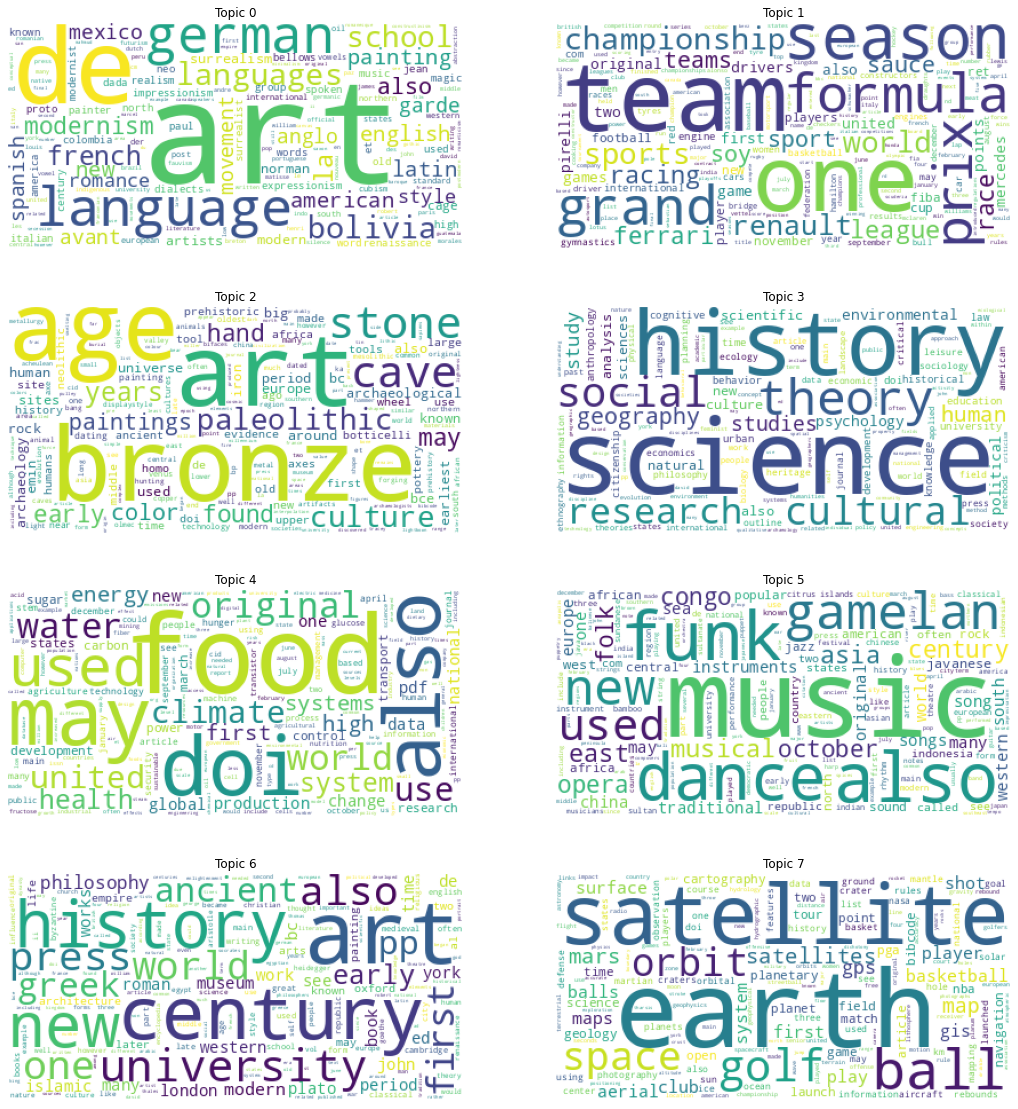

In [656]:
plot_cloud(model_test)

Prueba de **predict** con un artículo de deportes

In [663]:
sports_article = test[test['topic']=='sports'].iloc[3].text
sports_article

'Overview explanation of what constitutes a Formula One Grand Prix motor racing event. This article is about the racing events specifically. For a general overview of the sport, see Formula One. Formula One. Current season. 2022 Formula One World Championship. Related articles. History of Formula One. Formula One racing. Formula One regulations. Formula One cars. Formula One engines. Formula One tyres. Lists. Drivers (GP winnersPolesittersFastest laps ChampionsNumbers). Constructors (GP winnersChampions). Engine manufacturers (GP winnersChampions). SeasonsGrands PrixCircuits. Race Promoters\' Trophy winners. Points scoring systems. National coloursSponsorship liveries. Racing flagsRed-flagged races. Female driversTV broadcasters. FatalitiesVideo games. Records. Drivers. Constructors. Engines. Tyres. Races. Organisations. FIA. FIA World Motor Sport Council. Formula One Group. Liberty Media. Formula One Constructors\' Association. Formula One Teams Association. Grand Prix Drivers\' Assoc

In [664]:
model_test.predict(sports_article, debug=False)['topics']

2022-07-14 01:32:53.488275    sentences_as_words
2022-07-14 01:32:53.509727    remove_stopwords


[(1, 0.86821914), (4, 0.0821593), (5, 0.011458171), (6, 0.027743312)]

como podemos observar el **artículo tiene más probabilidad de pertenecer al tópico 1**, que corresponde a deportes como se puede observar en el wordcloud

# Definir todos los modelos a entrenar
Se creó un dataframe para incluir todos los modelos con los que se desea entrenar para hacer pruebas

In [665]:
models_to_train = []

# ###################################
# solo stopwords
# ###################################
models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 30
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 50
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 4, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 4, 'alpha': 'auto', 'per_word_topics': True, 'passes': 50
})

models_to_train.append({
    'steps': ['remove_stopwords']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 50
})


# ###################################
# solo ngrams
# ###################################
models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 10, 'threshold': 30
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})

models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 4, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 4, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': None, 'allowed_postags': None
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': False, 'passes': 30
})


# ###################################
# solo lematizando
# variando el modelo de spacy
# ###################################
models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_md', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 30
})


models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB','ADJ', 'ADV', 'PART'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 40
})


models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 7, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 100
})

# ###################################
# removiendo stopwords y lematizando
# pruebas cambiando los parametros del
# LDA model
# ###################################
models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 4, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 8, 'alpha': 'auto', 'per_word_topics': True, 'passes': 40
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 10
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 12, 'alpha': 'asymmetric', 'per_word_topics': False, 'passes': 10
})

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization']
    # NGrams params
    , 'ngrams': None, 'min_count': None, 'threshold': None
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 10
})


# ###################################
# removiendo stopwords, lematizando 
# y calculando ngrams
# ###################################

models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 3, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_lg', 'allowed_postags':  ['NOUN', 'VERB'] #'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 5, 'alpha': 'asymmetric', 'per_word_topics': True, 'passes': 20
})


models_to_train.append({
    'steps': ['remove_stopwords','lemmatization','ngram']
    # NGrams params
    , 'ngrams': 2, 'min_count': 5, 'threshold': 20
    # NLP model params (for lemmatization)
    , 'nlp_model': 'en_core_web_sm', 'allowed_postags':  ['NOUN', 'VERB'] # 'ADJ', 'ADV', 'PART'
    # LDA model params
    , 'topics': 7, 'alpha': 'auto', 'per_word_topics': True, 'passes': 20
})




In [666]:
pd.DataFrame(models_to_train)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes
0,[remove_stopwords],NaN,NaN,NaN,None,None,8,auto,True,10
1,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,30
2,[remove_stopwords],NaN,NaN,NaN,None,None,6,asymmetric,True,50
3,[remove_stopwords],NaN,NaN,NaN,None,None,4,asymmetric,False,20
4,[remove_stopwords],NaN,NaN,NaN,None,None,4,auto,True,50
5,[remove_stopwords],NaN,NaN,NaN,None,None,6,auto,True,50
6,[ngram],2.0,10.0,30.0,None,None,6,auto,True,20
7,[ngram],3.0,4.0,20.0,None,None,6,auto,True,20
8,[ngram],3.0,4.0,20.0,None,None,6,auto,False,30
9,[lemmatization],NaN,NaN,NaN,en_core_web_lg,"[NOUN, VERB]",8,auto,True,10


# Entrenar todos los modelos
Se entrenan todos los modelos y se obtiene la coherencia de cada uno. Los resultados se guardan en el dataframe

In [598]:
model_results = []
preparation_map = {}
data = train['text'].values.tolist()
validation_data = validation['text'].values.tolist()
for model_to_train in models_to_train:
    print('*******************************************')
    print(f'Start training model {len(model_results)+1}/{len(models_to_train)}')
    print('*******************************************')
    print(model_to_train)
    print('')
    
    # build model
    model = Model(
        data
        , stopwords=STOPWORDS
        , debug = False
        
        # pipeline
        , steps = model_to_train['steps']
        
        # NGrams params
        , ngrams = model_to_train['ngrams']
        , min_count = model_to_train['min_count']
        , threshold = model_to_train['threshold']
        
        # NLP model params (for lemmatization)
        , nlp_model = model_to_train['nlp_model']
        , allowed_postags = model_to_train['allowed_postags']
        
        # LDA model params
        , num_topics =  model_to_train['topics']
        , per_word_topics = model_to_train['per_word_topics']
        , passes = model_to_train['passes']
        , alpha = model_to_train['alpha']
        , random_state = 100
        , update_every = 1
        , chunksize = 100
    )
    
    # train model
    time_start_training = datetime.now()
    
    # pre process data (or check if data is in map already preprocessed)
    key = f"train;{model_to_train['steps']};{model_to_train['ngrams']};{model_to_train['min_count']};{model_to_train['threshold']};{model_to_train['nlp_model']};{model_to_train['allowed_postags']}"
    if key in preparation_map:
        result = preparation_map[key]
    else:
        result = model.preprocess(data)
        preparation_map[key] = result
    
    model.fit(result)
    train_min = (datetime.now()-time_start_training).total_seconds()/60.0
    print('Training time: '+'%.2f'%train_min+' min')
    
    # calculate coherence
    print('')
    print(f'{datetime.now()} coherence metric')
    time_start_eval = datetime.now()
    coherence_value = model.get_coherence_model(data).get_coherence()
    eval_sec = (datetime.now()-time_start_eval).total_seconds()
    print('Coherence: '+'%.6f'%coherence_value)
    print('Calculate Coherence time: '+'%.2f'%eval_sec+' seconds')
    
     # calculate coherence validation
    print('')
    print(f'{datetime.now()} coherence metric with validation data')
    time_start_eval = datetime.now()
    
    coherence_value_validation = model.get_coherence_model(validation_data).get_coherence()
    eval_sec = (datetime.now()-time_start_eval).total_seconds()
    print('Coherence validation: '+'%.6f'%coherence_value_validation)
    print('Calculate Coherence time: '+'%.2f'%eval_sec+' seconds')
    
    
    # append results
    model_results.append({**model_to_train,
                          'coherence_train':coherence_value,
                          'coherence_validation':coherence_value_validation,
                          'train_min':train_min,
                          'model':model})
    print('')

*******************************************
Start training model 1/1
*******************************************
{'steps': ['remove_stopwords'], 'ngrams': None, 'min_count': None, 'threshold': None, 'nlp_model': None, 'allowed_postags': None, 'topics': 6, 'alpha': 'auto', 'per_word_topics': True, 'passes': 10}

2022-07-14 01:06:42.412085    sentences_as_words
2022-07-14 01:06:51.512095    remove_stopwords
2022-07-14 01:06:52.425212  start
2022-07-14 01:06:52.425491    using preprocess data
2022-07-14 01:06:55.795349    creating model
2022-07-14 01:07:32.191318    creating coherence model
2022-07-14 01:07:32.203304  end
Training time: 0.83 min

2022-07-14 01:07:32.334810 coherence metric
Coherence: 0.532435
Calculate Coherence time: 23.00 seconds

2022-07-14 01:07:55.339758 coherence metric with validation data
Coherence validation: 0.497042
Calculate Coherence time: 14.79 seconds



In [599]:
df_results = pd.DataFrame(model_results)
df_results.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes,coherence_train,coherence_validation,train_min
0,[remove_stopwords],None,None,None,None,None,6,auto,True,10,0.532435,0.497042,0.832044


## Buscar mejor modelo
Se ordenó el dataframe según la coherencia para buscar el mejor modelo

In [600]:
df_results_sorted = df_results.sort_values(by=['coherence_validation'], ascending=False)
df_results_sorted.drop(['model'],axis=1)

,steps,ngrams,min_count,threshold,nlp_model,allowed_postags,topics,alpha,per_word_topics,passes,coherence_train,coherence_validation,train_min
0,[remove_stopwords],None,None,None,None,None,6,auto,True,10,0.532435,0.497042,0.832044


In [601]:
best_model=df_results_sorted.iloc[0]['model']

In [602]:
best_model.lda_model.print_topics()

[(0,
  '0.007*"science" + 0.007*"history" + 0.006*"theory" + 0.005*"social" + 0.004*"philosophy" + 0.004*"cultural" + 0.004*"also" + 0.004*"human" + 0.004*"new" + 0.004*"research"'),
 (1,
  '0.007*"one" + 0.007*"team" + 0.006*"season" + 0.006*"championship" + 0.005*"grand" + 0.005*"world" + 0.005*"prix" + 0.005*"formula" + 0.005*"sports" + 0.005*"renault"'),
 (2,
  '0.004*"history" + 0.004*"age" + 0.004*"early" + 0.004*"culture" + 0.003*"also" + 0.003*"ancient" + 0.003*"earth" + 0.003*"islamic" + 0.003*"bronze" + 0.003*"bc"'),
 (3,
  '0.007*"greek" + 0.006*"plato" + 0.004*"history" + 0.004*"goethe" + 0.003*"bc" + 0.003*"ancient" + 0.003*"thales" + 0.003*"enlightenment" + 0.003*"republic" + 0.003*"press"'),
 (4,
  '0.008*"food" + 0.004*"doi" + 0.004*"may" + 0.004*"also" + 0.003*"used" + 0.003*"original" + 0.003*"water" + 0.003*"world" + 0.003*"use" + 0.002*"climate"'),
 (5,
  '0.013*"art" + 0.011*"music" + 0.004*"century" + 0.004*"new" + 0.004*"also" + 0.003*"de" + 0.002*"painting" + 0.

## Graficar word clouds
Se graficó el word cloud de los tópicos obtenidos por el mejor modelo

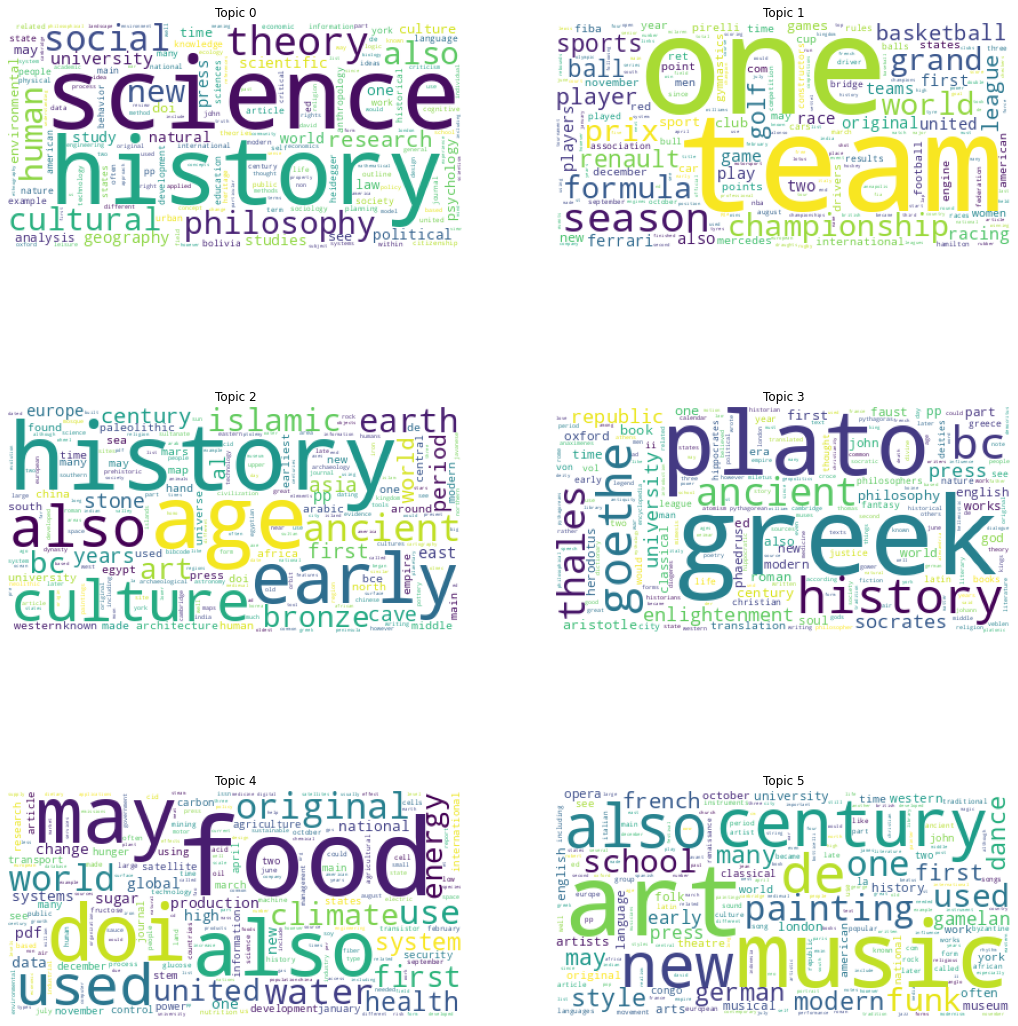

In [603]:
plot_cloud(best_model, export=False)

## Clasificación de tópicos
Revisar los tópicos obtenidos en el mejor modelo y buscar hacerles algún sentido

In [604]:
topic_class = {
    0: 'Ciencia',
    1: 'Deportes',
    2: 'Historia y Cultura',
    3: 'Filosofia',
    4: 'Comida',
    5: 'Arte y Musica'
}

def print_topics(model, text, topic_class=topic_class):
    for a in model.predict(text)['topics']:
        print(f'{topic_class[a[0]]}: {a[1]}')

## Sanity check
Aplicar la función de predict a artículos con tópico conocido y verificar qué tan bien clasifica el modelo

In [667]:
test[test['topic']=='sports'].iloc[3].title

'Formula One racing'

In [670]:
sports_article = test[test['topic']=='sports'].iloc[3].text
print(f"Titulo: {test[test['topic']=='sports'].iloc[3].title}")
print(f"Articulo: {sports_article}")

Titulo: Formula One racing
Articulo: Overview explanation of what constitutes a Formula One Grand Prix motor racing event. This article is about the racing events specifically. For a general overview of the sport, see Formula One. Formula One. Current season. 2022 Formula One World Championship. Related articles. History of Formula One. Formula One racing. Formula One regulations. Formula One cars. Formula One engines. Formula One tyres. Lists. Drivers (GP winnersPolesittersFastest laps ChampionsNumbers). Constructors (GP winnersChampions). Engine manufacturers (GP winnersChampions). SeasonsGrands PrixCircuits. Race Promoters' Trophy winners. Points scoring systems. National coloursSponsorship liveries. Racing flagsRed-flagged races. Female driversTV broadcasters. FatalitiesVideo games. Records. Drivers. Constructors. Engines. Tyres. Races. Organisations. FIA. FIA World Motor Sport Council. Formula One Group. Liberty Media. Formula One Constructors' Association. Formula One Teams Assoc

In [611]:
print_topics(best_model, sports_article)

2022-07-14 01:12:13.146303    sentences_as_words
2022-07-14 01:12:13.162816    remove_stopwords
Deportes: 0.9127134680747986
Comida: 0.04555864632129669
Arte y Musica: 0.031938157975673676


In [671]:
music_article = test[test['topic']=='music'].iloc[13].text
print(f"Titulo: {test[test['topic']=='music'].iloc[13].title}")
print(f"Articulo: {music_article}")

Titulo: Dynamics (music)
Articulo: Volume of a sound or note. "Fortissimo" and "Pianissimo" redirect here. For other uses, see Fortissimo (disambiguation) and Pianissimo (disambiguation). The beginning of the principal theme to the third movement of Berlioz's Symphonie fantastique showing examples of pianissimo (pp) and hairpins. In music, the dynamics of a piece is the variation in loudness between notes or phrases. Dynamics are indicated by specific musical notation, often in some detail. However, dynamics markings still require interpretation by the performer depending on the musical context: for instance, the forte marking f (meaning loud) in one part of a piece might have quite different objective loudness in another piece or even a different section of the same piece. The execution of dynamics also extends beyond loudness to include changes in timbre and sometimes tempo rubato. Contents. 1 Purpose and interpretation. 2 Dynamic markings. 2. 1 Changes. 2. 2 Extreme dynamic markings

In [631]:
print_topics(best_model, music_article)

2022-07-14 01:18:46.062907    sentences_as_words
2022-07-14 01:18:46.078386    remove_stopwords
Ciencia: 0.0603826679289341
Historia y Cultura: 0.02245664969086647
Comida: 0.11489983648061752
Arte y Musica: 0.8017655611038208


In [672]:
science_article = test[test['topic']=='science'].iloc[5].text
print(f"Titulo: {test[test['topic']=='science'].iloc[5].title}")
print(f"Articulo: {science_article}")

Titulo: Science (disambiguation)
Articulo: . Look up science in Wiktionary, the free dictionary. Science is a systematic enterprise for obtaining knowledge through testable explanations and predictions. Science may also refer to:. Contents. 1 Branches. 2 Literature. 3 Music. 4 Other uses. 5 See also. Branches. Natural science, the use of the scientific method to study the universe. Social science, the use of the scientific method to study society. Formal science, the study of rules, logic, and formal systems of information. Applied science, the study of technology. Mathematical science, the study of mathematical nature. Literature. Science (journal), the academic journal of the American Association for the Advancement of Science. Science (1979–1986 magazine), a general science magazine published by the AAAS as Science 80, merged into Discover. The Sciences, a popular science magazine published by the New York Academy of Sciences from 1961 to 2001. Music. S. C. I. E. N. C. E. , a 1997 a

In [644]:
print_topics(best_model, science_article)

2022-07-14 01:22:29.621614    sentences_as_words
2022-07-14 01:22:29.625431    remove_stopwords
Ciencia: 0.7542056441307068
Comida: 0.054416242986917496
Arte y Musica: 0.19051511585712433
